In [1]:
import sgml, sgutil, sgpp, dproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error

from proc_v2 import p
from ml_v2 import X_cat, X_num, X_all, target, kf, skf, ss, config, scheduler
from ml_v2 import xgb_adapter, lgb_adapter, cb_adapter, lr_adapter, nn_adapter

sc = sgutil.SGCache('img', 'result', 'model')
df_train = p.fit_transform(['data/train.csv']).assign(
    Calories_Log = lambda x: np.log(x['Calories'] + 1)
)
df_test = p.transform(['data/test.csv'])

2025-05-27 23:58:47.275428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 23:58:47.417198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748357927.470593    2684 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748357927.486344    2684 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748357927.633725    2684 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
models = ['lgb2', 'lgb1', 'xgb1', 'xgb3', 'cb1', 'cb2', 'cb3', 'cb4', 'cb5', 'nn1', 'nn2', 'cb7', 'cb8']
X_model = [i + '_skf5' if i not in ['cb7', 'cb8'] else i for i in models]
df_stk = sc.read_prds(X_model, index = df_train.index).assign(
    Calories_Log = df_train[target],
    duration_bin = pd.qcut(df_train['Duration'], q = 10, labels = np.arange(0, 10))
)

In [3]:
X_stk = [i + '_skf5' if i not in ['cb7', 'cb8'] else i for i in models]
hparams = {
    'X_num': X_stk
}
result = sgml.cv(df_stk, skf, hparams,  {**config, 'sp_y': 'duration_bin'}, lr_adapter)
np.mean(result['valid_scores'])

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

0.058976317507087664

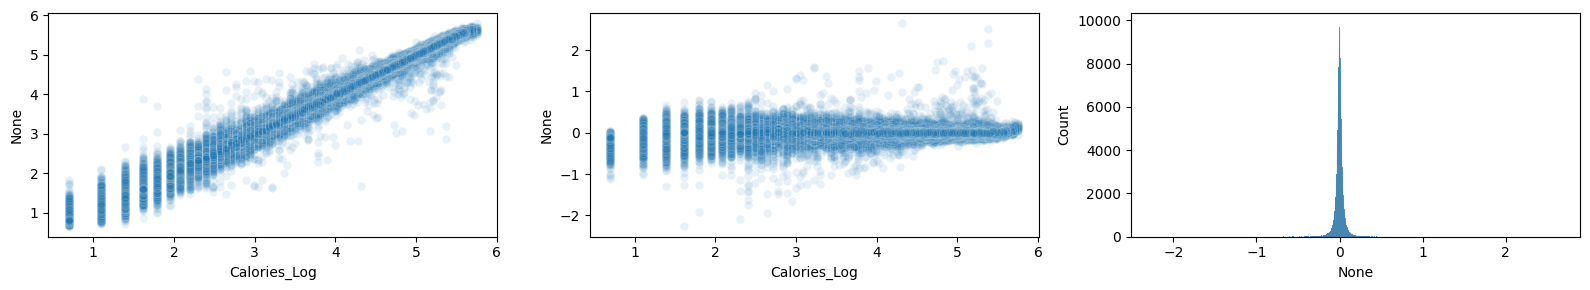

In [13]:
_, axes = plt.subplots(1, 3, figsize = (16, 3))
sns.scatterplot(
    x = df_train[target], y = result['valid_prd'], ax = axes[0], alpha = 0.1
)
res = df_train[target] - result['valid_prd']
sns.scatterplot(
    x = df_train[target], y = res, ax = axes[1], alpha = 0.1
)
sns.histplot(x = res, ax = axes[2])
plt.tight_layout()
plt.show()

In [11]:
res.describe()

count    750000.000000
mean         -0.000003
std           0.058977
min          -2.265499
25%          -0.019252
50%           0.000849
75%           0.020836
max           2.649000
dtype: float64

In [21]:
res.loc[res.between(*res.quantile([0.01, 0.99]))].pipe(
    lambda x: root_mean_squared_error(df_train.loc[x.index, target], result['valid_prd'].loc[x.index])
)

0.041245896864679533

['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']

In [ ]:
'Duration', '

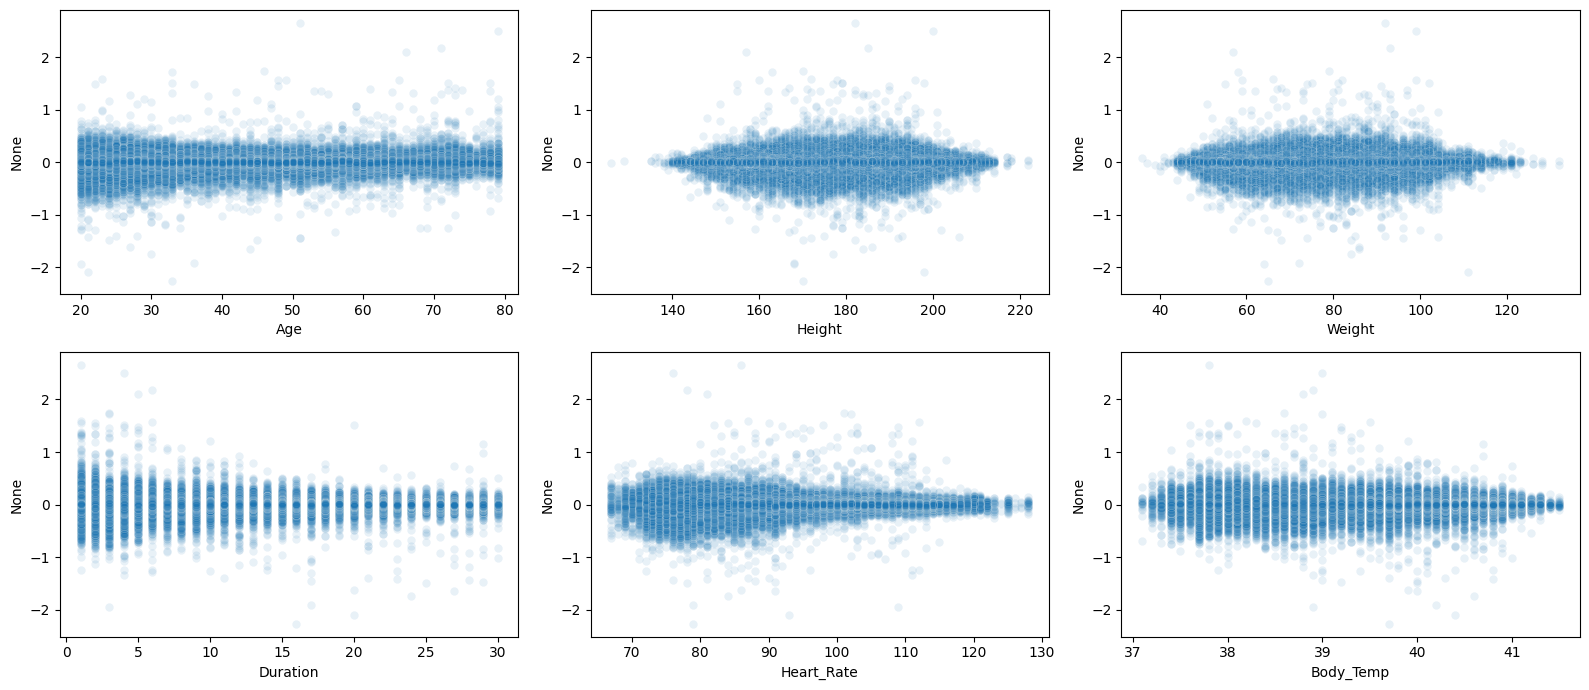

In [27]:
fig, axes = plt.subplots(2, 3, figsize = (16, 7))
axes = axes.flatten()
for i, ax in zip(X_num, axes):
    sns.scatterplot(
        x = df_train[i], y = res, alpha = 0.1, ax = ax
    )
plt.tight_layout()
plt.show()